# LIBARY

In [1]:
!nvidia-smi

Wed Jul 15 05:03:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    87W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/PPNCKH

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/PPNCKH


In [30]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [4]:
INIT_LR = 1e-4
EPOCHS = 40
BS = 32
tta_times = 10
imgSize = 512

# IMG PREPROCESSING

In [5]:
def change_brightness(img):
    value = random.randint(-10,15)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [6]:
def preprocessing(img):
    img = change_brightness(img)
    return img

# LOAD

In [7]:
trainAug = ImageDataGenerator(rotation_range=20, 
                              horizontal_flip = True,
                              shear_range=0.1,
                              channel_shift_range = 0.05,
                              fill_mode="nearest", 
                              rescale=1./255,
                              preprocessing_function = preprocessing,
                              validation_split=0.2)

testAug = ImageDataGenerator( rescale=1./255,
                              validation_split=0.2)

In [8]:
train_generator = trainAug.flow_from_directory('cropped/',
                                               target_size=(imgSize, imgSize),
                                               batch_size=BS,
                                               class_mode='categorical', 
                                               subset='training')

test_generator = testAug.flow_from_directory('cropped/',
                                              target_size=(imgSize, imgSize),
                                              batch_size=BS,
                                              class_mode='categorical', 
                                              subset='validation')

Found 2325 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


# MODEL

In [9]:
baseModel = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dense(64, activation="sigmoid")(headModel)
headModel = Dense(16, activation="elu")(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [10]:
best_val_acc = 0
best_train_acc = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    train_acc = logs['accuracy']
    global best_val_acc
    global best_train_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save('model_densenet201_v2.h5')
    elif val_acc == best_val_acc:
        if train_acc > best_train_acc:
            best_train_acc= train_acc
            model.save('model_densenet201_v2.h5')

In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BS,
    callbacks= [LambdaCallback(on_epoch_end=saveModel),
#              EarlyStopping(monitor='val_accuracy', patience=3),
#              ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=4),
              ],
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
72/72 [==============================] - 1946s 27s/step - loss: 1.1512 - accuracy: 0.8600 - val_loss: 0.6677 - val_accuracy: 0.8438
Epoch 2/40
72/72 [==============================] - 339s 5s/step - loss: 0.2059 - accuracy: 0.9363 - val_loss: 0.5998 - val_accuracy: 0.8993
Epoch 3/40
72/72 [==============================] - 334s 5s/step - loss: 0.2638 - accuracy: 0.9385 - val_loss: 0.2379 - val_accuracy: 0.9479
Epoch 4/40
72/72 [==============================] - 341s 5s/step - loss: 0.1631 - accuracy: 0.9612 - val_loss: 0.1937 - val_accuracy: 0.9514
Epoch 5/40
72/72 [==============================] - 281s 4s/step - loss: 0.1101 - accuracy: 0.9708 - val_loss: 0.2063 - val_accuracy: 0.9497
Epoch 6/40
72/72 [==============================] - 250s 3s/step - loss: 0.1557 - accuracy: 0.9625 - val_loss: 0.4394 - val_accuracy: 0.9219
Epoch 7/40
72/72 [==============================] - 303s 4s/step - loss: 0.1

KeyboardInterrupt: ignored

In [12]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

NameError: ignored

<Figure size 432x288 with 0 Axes>

# TEST

In [14]:
model= load_model('model_densenet201.h5')

In [32]:
def wrong_to_list(preds, generator):
    res = []
    for i in range(len(preds)):
        if (preds[i] != generator.labels[i]):
            res.append(generator.filenames[i])
    return res

def show_wrong_img(l):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    ten_random_samples = pd.Series(l).sample(min(len(l),10)).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join('cropped/', image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

## WITHOT TTA

### ON TRAIN

In [15]:
train = ImageDataGenerator(rescale=1./255,
                           validation_split=0.2).flow_from_directory('cropped/',
                                                                     target_size=(imgSize, imgSize),
                                                                     batch_size=BS,
                                                                     class_mode='categorical',
                                                                     shuffle = False,
                                                                     subset='training')

Found 2325 images belonging to 3 classes.


In [16]:
CName = {v: k for k, v in train.class_indices.items()}
predIdxs = model.predict_generator(train)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(train.labels, predIdxs, target_names=list(train.class_indices.keys()), digits = 5))

Instructions for updating:
Please use Model.predict, which supports generators.
                 precision    recall  f1-score   support

       COVID-19    1.00000   0.99432   0.99715       176
         NORMAL    0.99532   0.99161   0.99346      1073
Viral Pneumonia    0.99167   0.99628   0.99397      1076

       accuracy                        0.99398      2325
      macro avg    0.99567   0.99407   0.99486      2325
   weighted avg    0.99399   0.99398   0.99398      2325



In [17]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != train.labels[i]):
        print('Filename:',train.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(train.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[train.labels[i]])

Filename: COVID-19(194).png 		PRED: NORMAL 			TRUE: COVID-19
Filename: NORMAL (1325).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1332).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1335).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (144).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (152).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (274).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (540).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (63).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (918).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: Viral Pneumonia (1247).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (141).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (153).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (8).png 	PRED: NORMAL 			TRUE: Viral Pneumonia


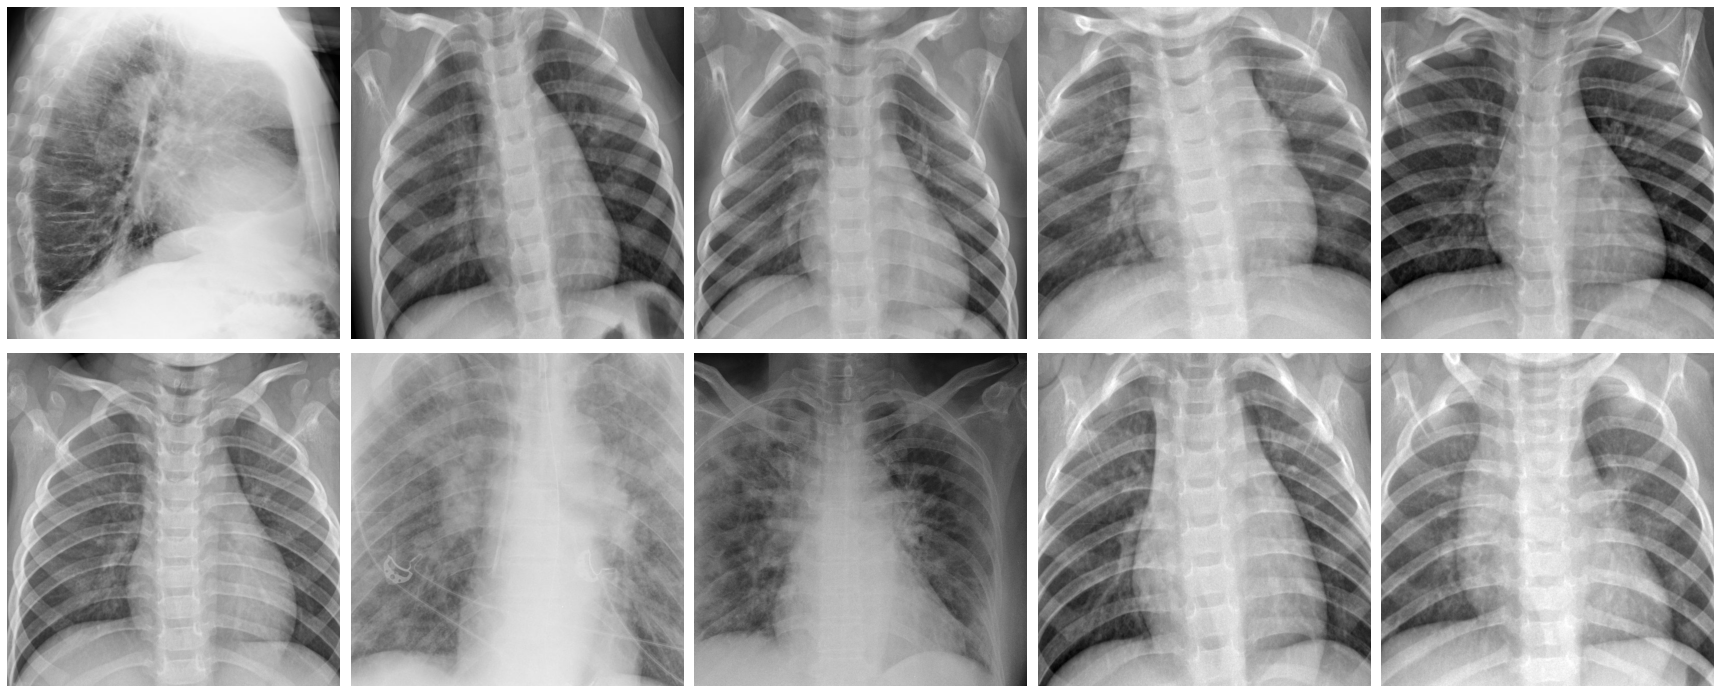

In [35]:
show_wrong_img(wrong_to_list(predIdxs, train))

### ON TEST

In [18]:
test = ImageDataGenerator(rescale=1./255, 
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                    target_size=(imgSize, imgSize),
                                                                    batch_size=BS,
                                                                    class_mode='categorical', 
                                                                    shuffle = False, 
                                                                    subset='validation')

Found 580 images belonging to 3 classes.


In [19]:
CName = {v: k for k, v in test.class_indices.items()}
predIdxs = model.predict_generator(test, verbose=1)
predIdxs = np.argmax(predIdxs, axis=1)

19/19 [==============================] - 28s 1s/step


In [20]:
print(classification_report(test.labels, predIdxs, target_names=list(test.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    1.00000   1.00000   1.00000        43
         NORMAL    0.97398   0.97761   0.97579       268
Viral Pneumonia    0.97761   0.97398   0.97579       269

       accuracy                        0.97759       580
      macro avg    0.98386   0.98386   0.98386       580
   weighted avg    0.97759   0.97759   0.97759       580



In [21]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != test.labels[i]):
        print('Filename:',test.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(test.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[test.labels[i]])

Filename: NORMAL (106).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1075).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1088).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1149).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1206).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1219).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: Viral Pneumonia (1003).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1023).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1041).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1072).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1107).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1141).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1237).png 	PRED: NORMAL 			TRUE: Viral Pneumonia


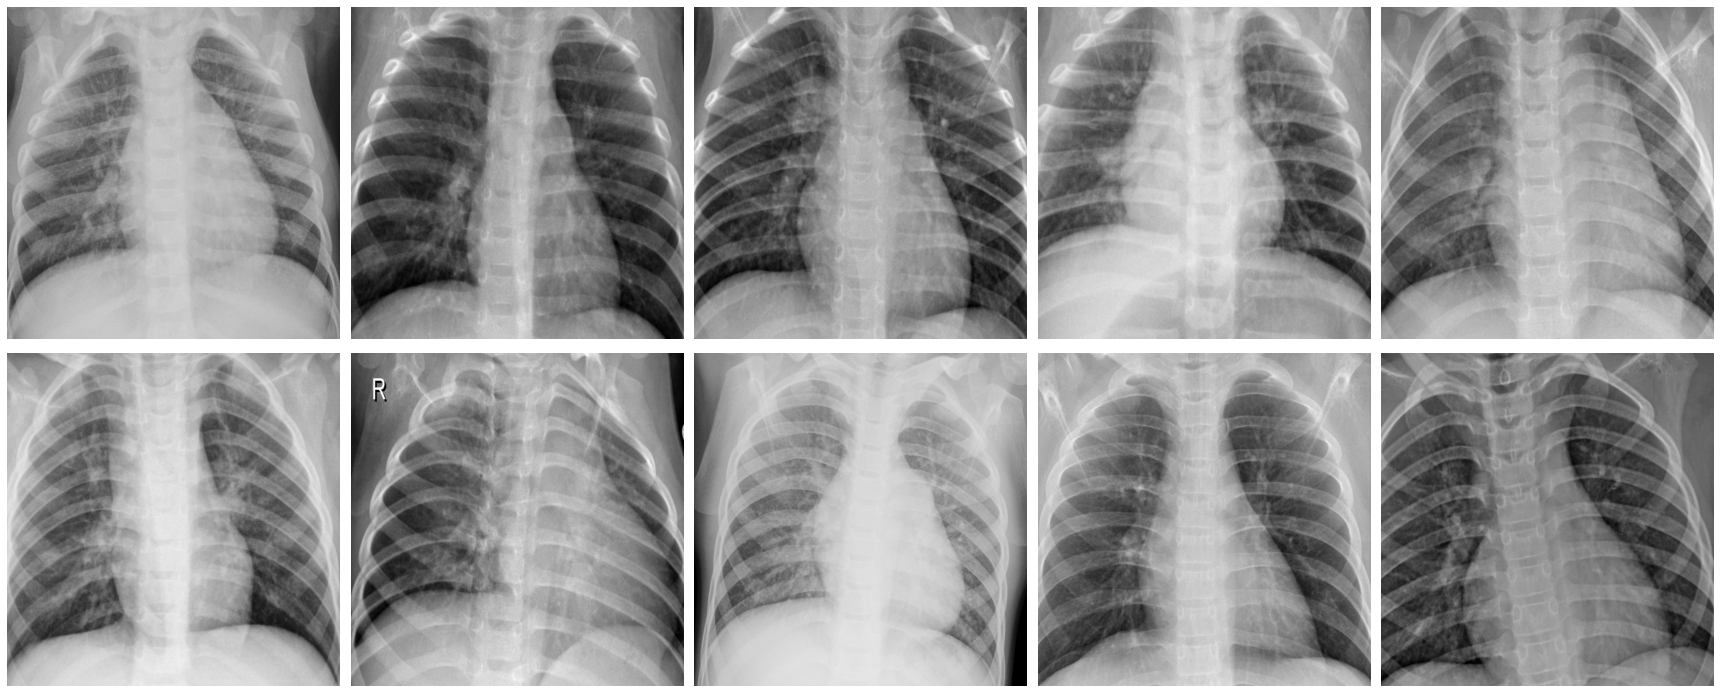

In [36]:
show_wrong_img(wrong_to_list(predIdxs, test))

## WITH TTA

### ON TRAIN

In [22]:
train = ImageDataGenerator(rotation_range=5, 
                          horizontal_flip = True,
                          shear_range=0.05,
                          zoom_range=0.05,
                          channel_shift_range = 0.025,
                          fill_mode="nearest", 
                          rescale=1./255,
                          preprocessing_function = preprocessing,
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                     target_size=(imgSize, imgSize),
                                                                     batch_size=BS,
                                                                     class_mode='categorical',
                                                                     shuffle = False,
                                                                     subset='training')
CName = {v: k for k, v in train.class_indices.items()}
probabilities = []
for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(train, verbose=1))
predIdxs = np.mean(probabilities, axis=0)
predIdxs = np.argmax(predIdxs, axis=1)

Found 2325 images belonging to 3 classes.
TTA Number:  0 

73/73 [==============================] - 218s 3s/step
TTA Number:  1 

73/73 [==============================] - 217s 3s/step
TTA Number:  2 

73/73 [==============================] - 217s 3s/step
TTA Number:  3 

73/73 [==============================] - 218s 3s/step
TTA Number:  4 

73/73 [==============================] - 217s 3s/step
TTA Number:  5 

73/73 [==============================] - 218s 3s/step
TTA Number:  6 

73/73 [==============================] - 219s 3s/step
TTA Number:  7 

73/73 [==============================] - 218s 3s/step
TTA Number:  8 

73/73 [==============================] - 219s 3s/step
TTA Number:  9 

73/73 [==============================] - 218s 3s/step
TTA Number:  10 

73/73 [==============================] - 219s 3s/step


In [23]:
print(classification_report(train.labels, predIdxs, target_names=list(train.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    1.00000   1.00000   1.00000       176
         NORMAL    1.00000   0.98882   0.99438      1073
Viral Pneumonia    0.98897   1.00000   0.99445      1076

       accuracy                        0.99484      2325
      macro avg    0.99632   0.99627   0.99628      2325
   weighted avg    0.99490   0.99484   0.99484      2325



In [24]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != train.labels[i]):
        print('Filename:',train.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(train.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[train.labels[i]])

Filename: NORMAL (1242).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1325).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1335).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (20).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (200).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (23).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (274).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (581).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (839).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (843).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (845).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (918).png 		PRED: Viral Pneumonia 		TRUE: NORMAL


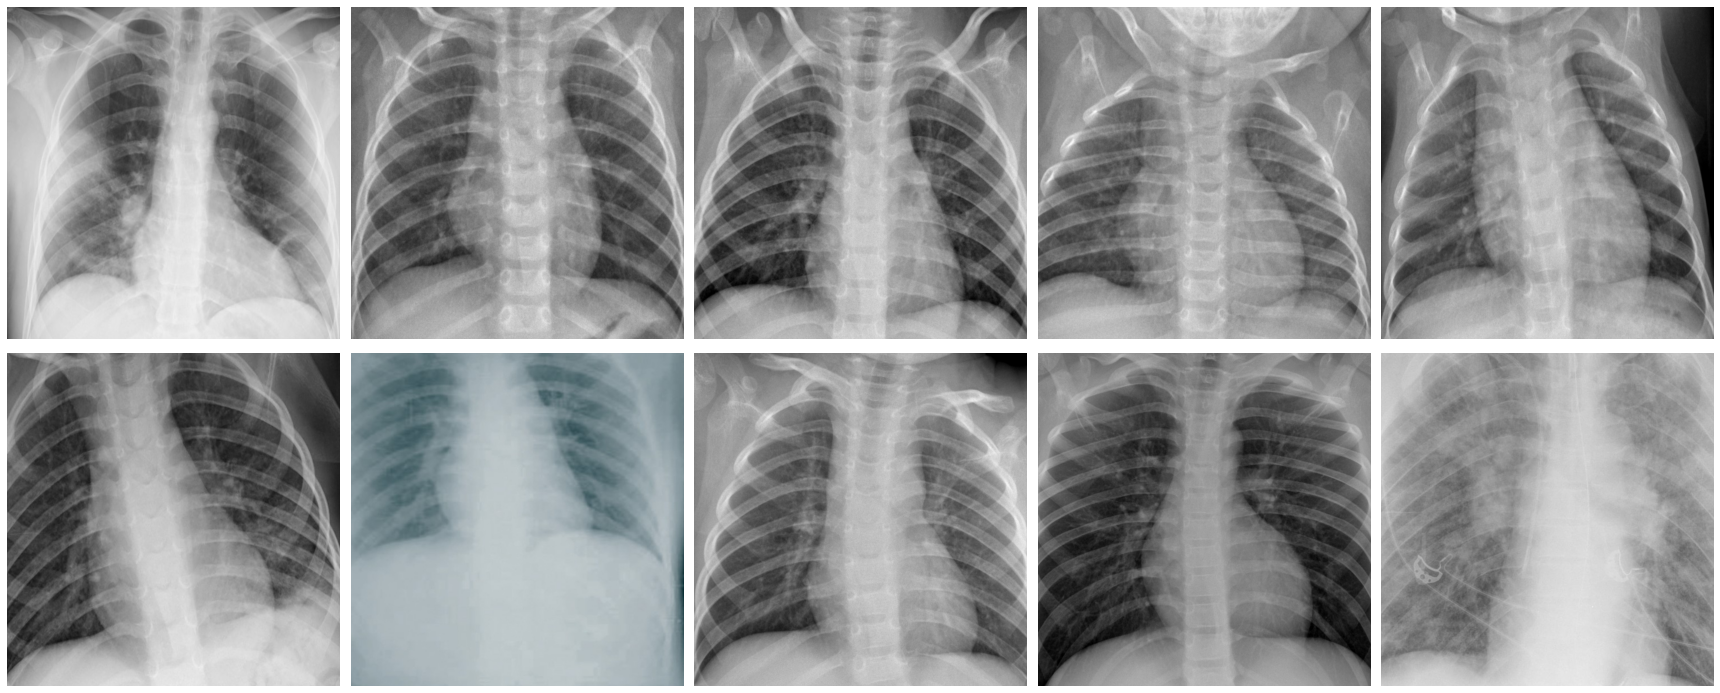

In [34]:
show_wrong_img(wrong_to_list(predIdxs, train))

### ON TEST

In [25]:
test = ImageDataGenerator(rotation_range=5, 
                          horizontal_flip = True,
                          shear_range=0.1,
                          zoom_range=0.05,
                          channel_shift_range = 0.025,
                          fill_mode="nearest", 
                          rescale=1./255,
                          preprocessing_function = preprocessing,
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                    target_size=(imgSize, imgSize),
                                                                    batch_size=BS,
                                                                    class_mode='categorical', 
                                                                    shuffle = False, 
                                                                    subset='validation')
CName = {v: k for k, v in test.class_indices.items()}
probabilities = []
for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(test, verbose=1))
predIdxs = np.mean(probabilities, axis=0)
predIdxs = np.argmax(predIdxs, axis=1)

Found 580 images belonging to 3 classes.
TTA Number:  0 

19/19 [==============================] - 52s 3s/step
TTA Number:  1 

19/19 [==============================] - 53s 3s/step
TTA Number:  2 

19/19 [==============================] - 53s 3s/step
TTA Number:  3 

19/19 [==============================] - 53s 3s/step
TTA Number:  4 

19/19 [==============================] - 53s 3s/step
TTA Number:  5 

19/19 [==============================] - 53s 3s/step
TTA Number:  6 

19/19 [==============================] - 53s 3s/step
TTA Number:  7 

19/19 [==============================] - 53s 3s/step
TTA Number:  8 

19/19 [==============================] - 53s 3s/step
TTA Number:  9 

19/19 [==============================] - 53s 3s/step
TTA Number:  10 

19/19 [==============================] - 53s 3s/step


In [26]:
print(classification_report(test.labels, predIdxs, target_names=list(test.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    1.00000   1.00000   1.00000        43
         NORMAL    0.97719   0.95896   0.96798       268
Viral Pneumonia    0.95985   0.97770   0.96869       269

       accuracy                        0.97069       580
      macro avg    0.97901   0.97888   0.97889       580
   weighted avg    0.97084   0.97069   0.97069       580



In [27]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != test.labels[i]):
        print('Filename:',test.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(test.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[test.labels[i]])

Filename: NORMAL (106).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1075).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1088).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1108).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1140).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1149).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1167).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1206).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1208).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1219).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1230).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: Viral Pneumonia (1003).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1023).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1041).png 	PRED: NORMAL 			TRUE: Viral Pneumonia
Filename: Viral Pneumonia (1072).png

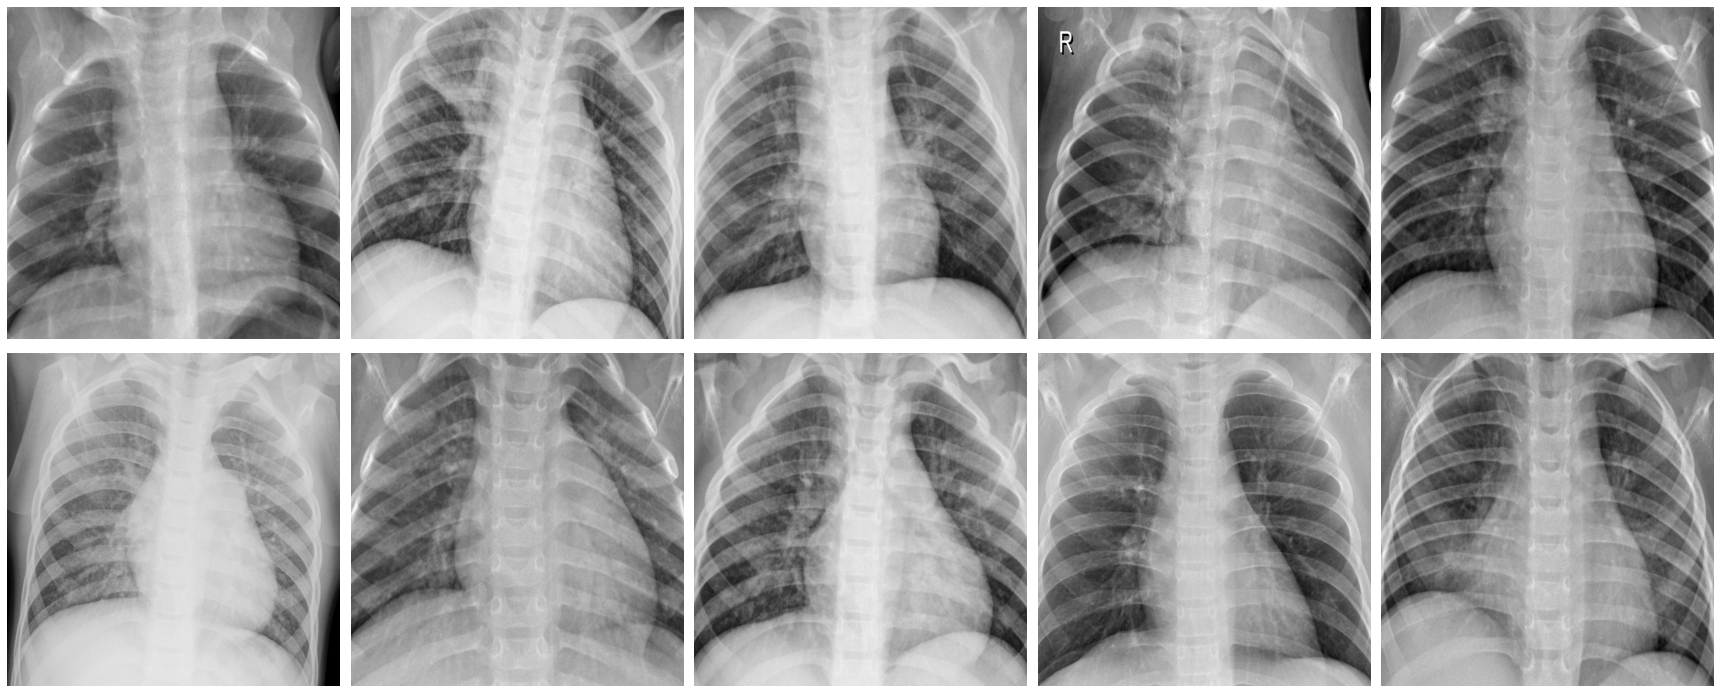

In [33]:
show_wrong_img(wrong_to_list(predIdxs, test))